In [42]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
df = pd.read_csv("plane.csv", delimiter=',', skiprows=0, low_memory=False)
df

,a,s,t,f,ep,tp
0,54,129,155,559,10.0,10.0
1,120,195,258,744,10.0,10.0
2,14,89,98,510,30.0,30.0
3,21,96,106,521,30.0,30.0
4,35,110,123,555,30.0,30.0
5,45,120,135,576,30.0,30.0
6,49,124,138,577,30.0,30.0
7,51,126,140,573,30.0,30.0
8,60,135,150,591,30.0,30.0
9,85,160,180,657,30.0,30.0


In [51]:
dfD = pd.read_csv("planedelay.csv", delimiter=',', skiprows=0, low_memory=False)
dfD

,1,2,3,4,5,6,7,8,9,10
0,99999,3,15,15,15,15,15,15,15,15
1,3,99999,15,15,15,15,15,15,15,15
2,15,15,99999,8,8,8,8,8,8,8
3,15,15,8,99999,8,8,8,8,8,8
4,15,15,8,8,99999,8,8,8,8,8
5,15,15,8,8,8,99999,8,8,8,8
6,15,15,8,8,8,8,99999,8,8,8
7,15,15,8,8,8,8,8,99999,8,8
8,15,15,8,8,8,8,8,8,99999,8
9,15,15,8,8,8,8,8,8,8,99999


In [57]:
model = AbstractModel()
model.N =Param(mutable=True, initialize=len(df)) 
model.i = RangeSet(1,model.N)
model.j=Set(initialize=model.i)
def limPlane(model,i):
    return (df.loc[i-1,'s'],df.loc[i-1,'f'])
model.x = Var(model.i,domain=PositiveReals, bounds=limPlane)

model.EN = Var(model.i,domain=PositiveReals, bounds=(0,500))
model.TN = Var(model.i,domain=PositiveReals, bounds=(0,500))

model.U = Var(model.i,model.j,domain=Binary)

def rule_D(model,i,j):
    return dfD.iloc[i-1,j-1]
model.D=Param(model.i,model.j, initialize=rule_D, mutable=True)
model.ep = Param(model.i, mutable=True)
model.tp = Param(model.i, mutable=True)
model.target = Param(model.i, mutable=True)

def rue_c1(model,i):
    return -model.x[i]+model.target[i]<=model.EN[i]
model.C1 =Constraint(model.i,rule=rue_c1)

def rue_c2(model,i):
    return model.x[i]-model.target[i]<=model.TN[i]
model.C2 =Constraint(model.i, rule=rue_c2)

def rue_c3(model,i,j):
    if i!=j:
        return model.x[i]+model.D[i,j]*model.U[i,j]- 1000*(1-model.U[i,j]) <=model.x[j] 
    else:
        return Constraint.Skip 
model.C3 =Constraint(model.i,model.j, rule=rue_c3)

def rue_c4(model,i,j):
    if i!=j:
        return model.U[i,j]+model.U[j,i]==1 
    else:
        return Constraint.Skip 
model.C4 =Constraint(model.i,model.j, rule=rue_c4)

def rule_OF(model):
    return sum(model.ep[i]*model.EN[i]+model.tp[i]*model.TN[i] for i in model.i)
model.obj = Objective(rule=rule_OF, sense=minimize)


In [58]:
instance = model.create_instance()
for i in instance.i:
    instance.target[i]=df.loc[i-1,'t']
    instance.ep[i]=df.loc[i-1,'ep']
    instance.tp[i]=df.loc[i-1,'tp']

In [59]:
opt = SolverFactory('glpk')
results=opt.solve(instance)
print('OF= ',value(instance.obj))
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print (str(results.solver))

OF=  700.0
this is feasible and optimal


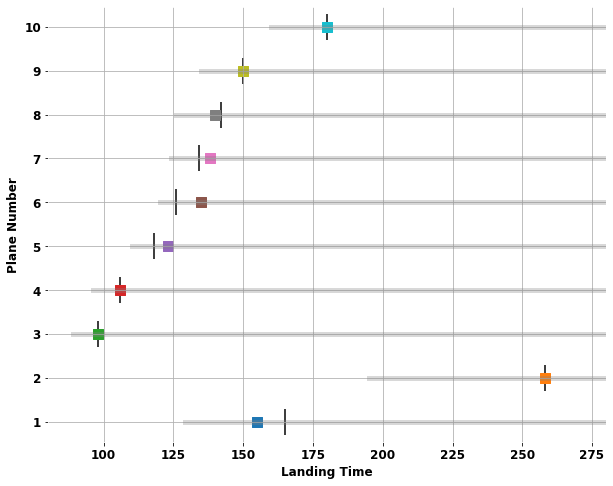

In [91]:
plt.figure(figsize=(10,8))
for i in instance.i:
    #print(i,value(instance.x[i]),value(instance.EN[i]),value(instance.TN[i]) )
    plt.plot((df.loc[i-1,'s'],df.loc[i-1,'f']) ,(i,i),lw=5, c='grey', alpha=0.3)
    plt.scatter(value(instance.x[i]),i,marker='|', s=700, c='k')
    plt.scatter(value(instance.target[i]),i,marker='s',s=100)
plt.xlim(80,280)
plt.grid()
plt.ylabel('Plane Number', fontweight='bold', fontsize=12)
plt.xlabel('Landing Time', fontweight='bold', fontsize=12)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks([i for i in range(1,11)],fontweight='bold', fontsize=12)
plt.rc('axes',edgecolor='w')
